In [1]:
from pathlib import Path
import pickle
import copy

import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.10.4+0.x64.w64.mingw32. You currently have `1.10.3+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
cwd = Path().cwd()

# Setting up the system

In [4]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=3 / 2, F=1
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=3 / 2, F=2
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=5 / 2, F=2
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=5 / 2, F=3
    ),
]

polarizations = [
    [
        couplings.polarization_σp,
        couplings.polarization_σm,
    ],
    [
        couplings.polarization_σp,
        couplings.polarization_σm,
    ],
    [
        couplings.polarization_σp,
        couplings.polarization_σm,
    ],
    [
        couplings.polarization_σp,
        couplings.polarization_σm,
    ],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [5]:
odepars = lindblad_julia.odeParameters(
    Ω0=hamiltonian.Γ,
    δ0=0.0,
    Ω1=hamiltonian.Γ,
    δ1=0.0,
    Ω2=hamiltonian.Γ,
    δ2=0.0,
    Ω3=hamiltonian.Γ,
    δ3=0.0,
    # polarization modulation
    Pl0="sin(ωl*t+ϕl0)",
    Pσp0="Pl0<0",
    Pσm0="Pl0>=0",
    Pl1="sin(ωl*t+ϕl1)",
    Pσp1="Pl1<0",
    Pσm1="Pl1>=0",
    Pl2="sin(ωl*t+ϕl2)",
    Pσp2="Pl2<0",
    Pσm2="Pl2>=0",
    Pl3="sin(ωl*t+ϕl3)",
    Pσp3="Pl3<0",
    Pσm3="Pl3>=0",
    ωl=2 * np.pi * 1e6,
    ϕl0=0.0,
    ϕl1=0.0,
    ϕl2=0.0,
    ϕl3=0.0,
)

In [6]:
%%time
obe_system_original = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=states.QuantumSelector(J=3, electronic=states.ElectronicState.X),
    decay_channels=None,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 1min 41s
Wall time: 2min 6s


In [8]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system_original, transition_selectors, odepars
)

In [9]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 2, F₁ = 3/2, F = 1>","|B, J = 2, F₁ = 3/2, F = 2>","|B, J = 2, F₁ = 5/2, F = 2>","|B, J = 2, F₁ = 5/2, F = 3>"
states,,,,
"|X, J = 1>",0.709417,0.711856,0.525007,0.523531
"|X, J = 3>",0.290583,0.288144,0.474993,0.476469


In [10]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X), obe_system.QN
)

# Single parameter only

In [11]:
for coupling in obe_system.couplings:
    print(
        round(
            utils.rabi.intensity_to_rabi(
                10e-3 / (25.4e-3 * 25.4e-3),
                coupling.main_coupling.real,
                D=2.6675506e-30,
            )
            / hamiltonian.Γ,
            3,
        )
    )

-0.008
-0.04
0.043
0.128


In [12]:
odepars.Ω0 = 0.008 * hamiltonian.Γ
odepars.Ω1 = 0.04 * hamiltonian.Γ
odepars.Ω2 = 0.043 * hamiltonian.Γ
odepars.Ω3 = 0.128 * hamiltonian.Γ
odepars.δ0 = 0.0 * hamiltonian.Γ
odepars.δ1 = 0.0 * hamiltonian.Γ
odepars.δ2 = 0.0 * hamiltonian.Γ
odepars.δ3 = 0.0 * hamiltonian.Γ
odepars.ωl = 2 * np.pi * 0.2e6
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 100e-6))
config = lindblad_julia.OBEProblemConfig(
    method="Tsit5()", saveat=1e-6, abstol=1e-13, reltol=1e-10
)

results = lindblad_julia.do_simulation_single(problem, config=config)

In [13]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

qn_select_J1 = states.QuantumSelector(J=1, electronic=states.ElectronicState.X)
indices_J1 = qn_select_J1.get_indices(obe_system.QN)

qn_select_J3 = states.QuantumSelector(J=3, electronic=states.ElectronicState.X)
indices_J3 = qn_select_J3.get_indices(obe_system.QN)

2.56 photons


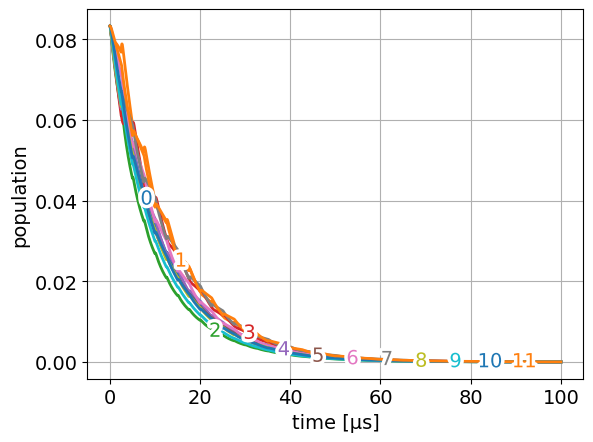

In [14]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_J1].T, lw=2, label=indices_J1)

labelLines(ax.get_lines(), align=False, fontsize=14)

# ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

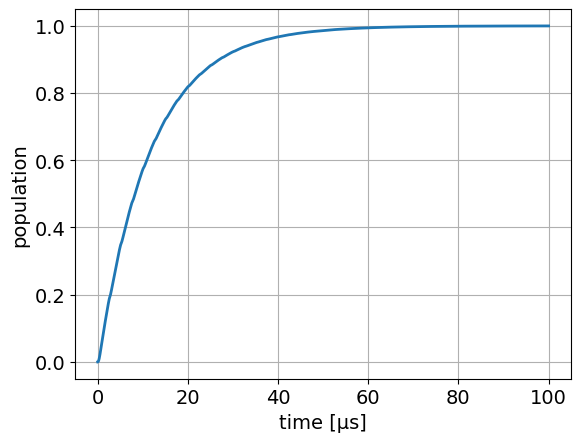

In [15]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J3].T, lw=2)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()